In [ ]:
import h5py
import numpy as np
import os
from tqdm import tqdm
import illustris_python as il
import matplotlib.pyplot as plt
import multiprocessing as mp

basePath='./sims.TNG/TNG100-1/output'
hdf5_File_Path = './APMS_TNG100_hdf5_z12'
hdf5_files = [f for f in os.listdir(hdf5_File_Path) if f.endswith('.hdf5')]

In [ ]:
with h5py.File(os.path.join(hdf5_File_Path, hdf5_files[0]), "r") as f:
    for key in f.keys():
        print(key, f[key].shape)

In [ ]:
def Apply_Periodic_Boundary_Condition(Coordinates_Differences, Snapshots):
    Modified_Differences=list()
    for coordinate_difference, snapshot in zip(Coordinates_Differences, Snapshots):
        scale_factor=il.groupcat.loadHeader(basePath, snapshot)['Time']
        box_size=il.groupcat.loadHeader(basePath, snapshot)['BoxSize']
        current_physical_box_size=box_size*scale_factor

        if coordinate_difference[0]>current_physical_box_size/2:
            coordinate_difference[0]-=current_physical_box_size
        elif coordinate_difference[0]<-current_physical_box_size/2:
            coordinate_difference[0]+=current_physical_box_size

        if coordinate_difference[1]>current_physical_box_size/2:
            coordinate_difference[1]-=current_physical_box_size
        elif coordinate_difference[1]<-current_physical_box_size/2:
            coordinate_difference[1]+=current_physical_box_size

        if coordinate_difference[2]>current_physical_box_size/2:
            coordinate_difference[2]-=current_physical_box_size
        elif coordinate_difference[2]<-current_physical_box_size/2:
            coordinate_difference[2]+=current_physical_box_size

        Modified_Differences.append(coordinate_difference)

    return np.array(Modified_Differences)

In [ ]:
for file_name in tqdm(hdf5_files):
    with h5py.File(os.path.join(hdf5_File_Path, file_name), "r") as f:
        for key in f.keys():
            globals()[key] = f[key][()]



In [38]:
def Add_Modified_Distance(File_Path):
    with h5py.File(File_Path, "r") as f:
        modified_distance=Apply_Periodic_Boundary_Condition(f['MMSG_Position'][()]-f['Host_Position'][()], f['Snapshots'][()])

    with h5py.File(File_Path, "a") as f:
        if f.keys().__contains__('Modified_Distance'):
            del f['Modified_Distance']
        f.create_dataset('Modified_Difference', data=modified_distance)



In [ ]:
for i in range(0,10):
    Add_Modified_Distance(os.path.join(hdf5_File_Path, hdf5_files[i]))

In [39]:
def Process_Subindex(Init_Subindex,End_Subindex):
    for i in tqdm(range(Init_Subindex,End_Subindex)):
        Add_Modified_Distance(os.path.join(hdf5_File_Path, hdf5_files[i]))

In [40]:
num_processes=32
subindex_list=np.linspace(0,len(hdf5_files),num_processes+1).astype(int)


In [41]:
Processes=list()
for i in range(0,num_processes):
    Processes.append(mp.Process(target=Process_Subindex, args=(subindex_list[i],subindex_list[i+1])))
    Processes[-1].start()

for process in Processes:
    process.join()


  0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 138/138 [01:32<00:00,  1.49it/s]


(4, 3)


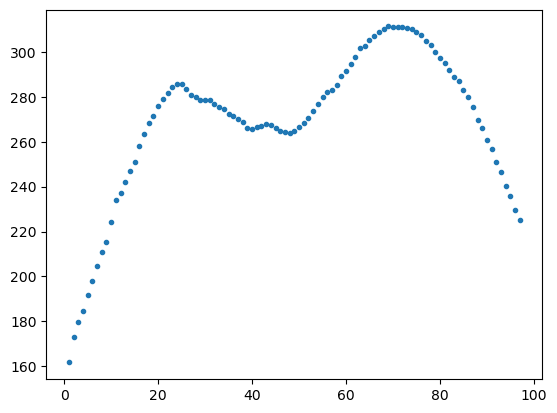

In [44]:
with h5py.File(os.path.join(hdf5_File_Path, hdf5_files[2]), "r") as f:
    print(Extremum_Num(np.sqrt(np.sum(f['Modified_Difference'][()]**2,axis=1))))
    plt.plot(np.sqrt(np.sum(f['Modified_Difference'][()]**2,axis=1)),'.')